### Objective

We're going to take a look at a company that sells a service of providing information via HTTP. 

With the increasing success of our company, the demand for better infrastructure also increases to serve all incoming web requests successfully. 

We don't want to allocate too many resources as that would be too costly. 

On the other hand, we will lose money if we have not reserved enough resources for serving all incoming requests. 


Our question is therefore, when will we hit the limit of our current infrastructure, which we estimated being 100,000 requests per hour?

We would like to know in advance when we have to request additional servers in the cloud to serve all the incoming requests successfully without paying for unused ones.



### Read in data

Let's read in our data, which is an hourly count of hits for a month.


In [1]:
import numpy as np
import scipy as sp
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv("../data/web_traffic.tsv", delimiter="\t")

Let's take a look

In [3]:
data.head(3)

,1,2272
0,2,NaN
1,3,1386.0
2,4,1365.0


In [4]:
# all examples will have three classes in this file
colors = ['g', 'k', 'b', 'm', 'r']
linestyles = ['-', '-.', '--', ':', '-']


In [5]:
x = data.iloc[:, 0]
y = data.iloc[:, 1]
print("Number of invalid entries:", sp.sum(sp.isnan(y)))
# x = x[~sp.isnan(y)]
# y = y[~sp.isnan(y)]

Number of invalid entries: 8


Let's remove some invalid data

In [6]:
x = x[~sp.isnan(y)]
y = y[~sp.isnan(y)]

### Explore the data

Let's get a feeling for what we're dealing with

In [7]:
def plot_models(x, y, models, fname, mx=None, ymax=None, xmin=None):
    plt.clf()
    plt.scatter(x, y, s=10)
    plt.title("Web traffic over the last month")
    plt.xlabel("Time")
    plt.ylabel("Hits/hour")
    plt.xticks(
        [w * 7 * 24 for w in range(10)], ['week %i' % w for w in range(10)])

    if models:
        if mx is None:
            mx = sp.linspace(0, x.iloc[-1], 1000)
        for model, style, color in zip(models, linestyles, colors):
            # print "Model:",model
            # print "Coeffs:",model.coeffs
            plt.plot(mx, model(mx), linestyle=style, linewidth=2, c=color)

        plt.legend(["d=%i" % m.order for m in models], loc="upper left")

    plt.autoscale(tight=True)
    plt.ylim(ymin=0)
    if ymax:
        plt.ylim(ymax=ymax)
    if xmin:
        plt.xlim(xmin=xmin)
    plt.grid(True, linestyle='-', color='0.75')
    plt.savefig(fname)

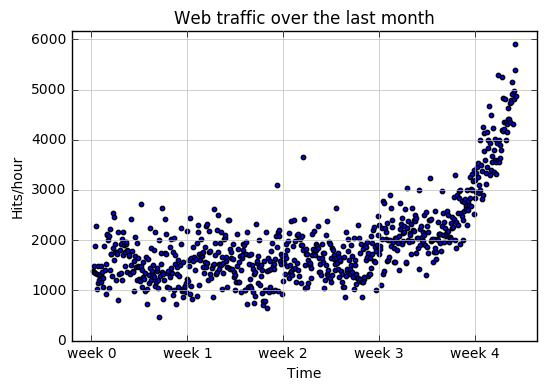

In [8]:
plot_models(x, y, None, "../figures/1400_01_01.png")

From this chart we can see that while in the first weeks the traffic stayed more or less the same, the last week shows a steep increase:


### So how long will our server handle the incoming web traffic?

To get to the answer, we'll remove noise and extrapolate our model into the future to find the point in time where our limit is reached

In [9]:
# This error will be calculated as the squared distance
# of the model's prediction to the real data
def error(f, x, y):
    return sp.sum((f(x)-y)**2)

Now lets create and plot our models

We'll start our assuming our data fits a straight line and isn't a polynomial.

To do this we'll approximate our error and choose the best model from this.

We'll use scipy's `polyfit()` function which will approximate our error and find the model that minimizes our error function above

In [10]:
fp1, res, rank, sv, rcond = sp.polyfit(x, y, 1, full=True)

The `polyfit()` function returns the parameters of the fitted model function, `fp1`

By setting `full` to `True`, we also get additional background information on the fitting process. 

Of it, only residuals are of interest, which is exactly the error of the approximation.

In [11]:
print("Model parameters: %s" %  fp1)
print(res)


Model parameters: [   2.61052204  981.90184838]
[  3.15741295e+08]


This means that the best straight line fit is the following function

f(x) = 2.61052204 * x + 981.90184838

Now we'll use `poly1d()` to create a model function from our model parameters above

In [12]:
f1 = sp.poly1d(fp1)

In [13]:
print(error(f1, x, y))

315741295.2974617


Let's plot and see our model

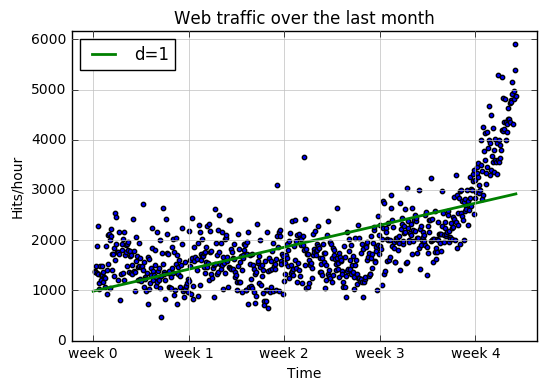

In [14]:
plot_models(x, y, [f1], "../figures/1400_01_02.png")

Thoughts:
* It seems like the first four weeks are not that far off, 
    * Although we clearly see that there is something wrong with our initial assumption that the underlying model is a straight line. 
* Our error of 315741295.2974617 seems huge so we have to figure out if that's a bad number or a good number
* For now it's our baseline


### Polynomial of d degrees

Let's see whether adding degrees to our polynomials gives us a better fit aka lowers the error / residuals

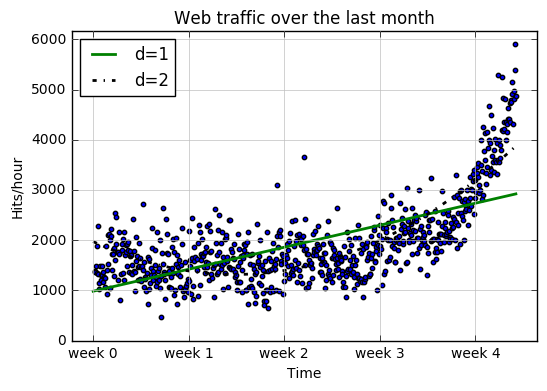

In [15]:
f2 = sp.poly1d(sp.polyfit(x, y, 2))
plot_models(x, y, [f1, f2], "../figures/1400_01_03.png")


In [16]:
print (f2)

print(error(f2, x, y))

         2
0.01051 x - 5.245 x + 1971
179890848.74033266


Seems like our error is way down ~half, so we're on the right path.

The fitted polynomial of degree 2 now looks like

f(x) = 0.01051 x - 5.245 x + 1971

Let's try some more

//anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RankWarning: Polyfit may be poorly conditioned
  app.launch_new_instance()


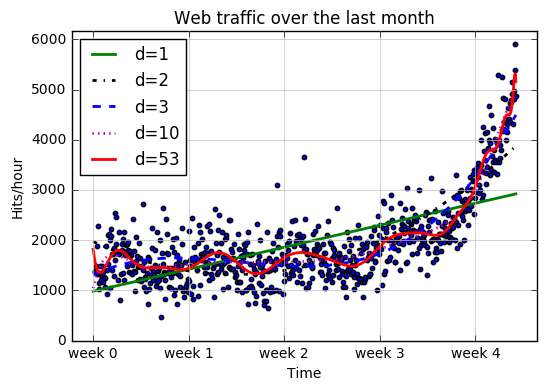

In [17]:
f3 = sp.poly1d(sp.polyfit(x, y, 3))
f10 = sp.poly1d(sp.polyfit(x, y, 10))
f100 = sp.poly1d(sp.polyfit(x, y, 100))

plot_models(
    x, y, [f1, f2, f3, f10, f100], 
    "../figures/1400_01_04.png")

In [18]:
print (f2)
print (f3)
print (f10)
print (f100)

print(error(f2, x, y))
print(error(f3, x, y))
print(error(f10, x, y))
print(error(f100, x, y))

         2
0.01051 x - 5.245 x + 1971
           3           2
3.095e-05 x - 0.02417 x + 5.158 x + 1312
            10             9             8             7             6
-5.016e-22 x  + 1.863e-18 x - 2.978e-15 x + 2.685e-12 x - 1.501e-09 x
              5             4          3         2
 + 5.389e-07 x - 0.0001238 x + 0.0175 x - 1.391 x + 50.74 x + 1043
             53              52              51              50
-7.581e-140 x  + 1.359e-136 x  - 6.313e-135 x  - 5.328e-131 x 
               49              48              47              46
 - 2.844e-128 x  + 3.116e-126 x  + 1.604e-122 x  + 1.312e-119 x 
              45              44             43              42
 + 4.69e-117 x  - 1.911e-114 x  - 4.37e-111 x  - 3.628e-108 x 
               41              40             39             38
 - 1.621e-105 x  + 1.415e-103 x  + 1.011e-99 x  + 1.043e-96 x 
              37             36             35             34
 + 6.173e-94 x  + 1.275e-91 x  - 1.907e-88 x  - 2.809e-85 x 
  

As you see, it gets more complicated with each degree added.

So now the question is whether there's a large enough difference between errors of d=10 and d=100 to offset the complexity

It also seems to be overfitting with d=100 given that the curve oscillates a ton.  This raises the question of whether it'd generalize well or if it just fits this training data extra well.

This is where cross validation comes in but I won't go into it today

### Evaluation 1

Of the five fitted models, the first-order model clearly is too simple, and the models of order 10 and 100 are clearly overfitting.

Only the second- and third-order models seem to somehow match the data. 

However, if we extrapolate them at both borders, we see them going failing.

At this point, we realize that we probably have not completely understood our data.

### Let's go back and look at our data again

It seems that there is an inflection point between weeks 3 and 4.

Meaning that's where we see it ramp up

So let us separate the data and train two lines using week 3.5 as a separation point. 

We train the first line with the data up to week 3, and the second line with the remaining data.

In [19]:
inflection = 3.5 * 7 * 24
xa = x.iloc[:int(inflection)]
ya = y.iloc[:int(inflection)]
xb = x.iloc[int(inflection):]
yb = y.iloc[int(inflection):]

In [20]:
fa = sp.poly1d(sp.polyfit(xa, ya, 1))
fb = sp.poly1d(sp.polyfit(xb, yb, 1))

In [21]:
fa_error = error(fa, xa, ya)
fb_error = error(fb, xb, yb)

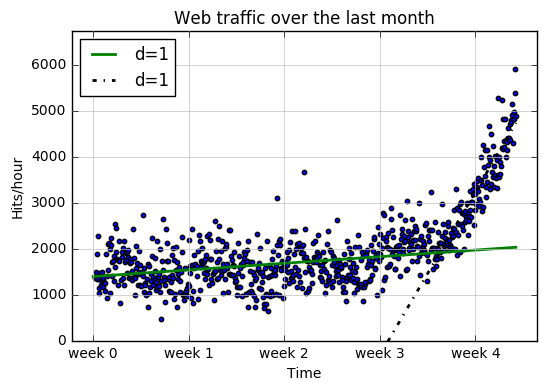

In [22]:
plot_models(x, y, [fa, fb], "../figures/1400_01_05.png")

In [23]:
print("Errors for the complete data set:")
for f in [f1, f2, f3, f10, f100]:
    print("Error d=%i: %f" % (f.order, error(f, x, y)))


Errors for the complete data set:
Error d=1: 315741295.297462
Error d=2: 179890848.740333
Error d=3: 138458295.737893
Error d=10: 120791850.285017
Error d=53: 109306177.854341


In [24]:
print("Errors for only the time after inflection point")
for f in [f1, f2, f3, f10, f100]:
    print("Error d=%i: %f" % (f.order, error(f, xb, yb)))


Errors for only the time after inflection point
Error d=1: 144286788.493258
Error d=2: 60857994.971012
Error d=3: 32907173.841400
Error d=10: 21738607.284475
Error d=53: 18657929.525993


In [25]:
print("Error inflection=%f" % (error(fa, xa, ya) + error(fb, xb, yb)))

Error inflection=132069916.166944


From this we seem to find the combination of these two lines to be a much better fit to the data than anything we have modeled before.

But still, the combined error is higher than the higher-order polynomials. Can we trust the error at the end?

Asked differently, why do we trust the straight line fitted only at the last week of our data more than any of the more complex models? 

It is because we assume that it will capture future data better. If we plot the models into the future, we see how right we are (d=1 is again our initially straight line).

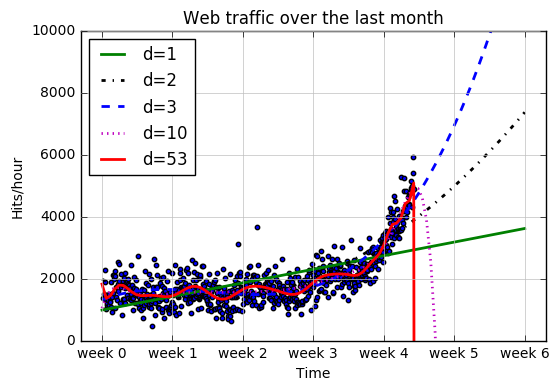

In [26]:
# extrapolating into the future
plot_models(
    x, y, [f1, f2, f3, f10, f100], "../figures/1400_01_06.png",
    mx=sp.linspace(0 * 7 * 24, 6 * 7 * 24, 100),
    ymax=10000, xmin=0 * 7 * 24)


The models of degree 10 and 100 don't seem to expect a bright future for us. 

So that's no bueno.

They tried so hard to model the given data correctly that they are clearly useless to extrapolate further. This is called overfitting. 

On the other hand, the lower-degree models do not seem to be capable of capturing the data properly. This is called underfitting.

In [30]:
print("Trained only on data after inflection point")
fb1 = fb
fb2 = sp.poly1d(sp.polyfit(xb, yb, 2))
fb3 = sp.poly1d(sp.polyfit(xb, yb, 3))
fb10 = sp.poly1d(sp.polyfit(xb, yb, 10))
fb100 = sp.poly1d(sp.polyfit(xb, yb, 100))
print ()
print("Errors for only the time after inflection point")
for f in [fb1, fb2, fb3, fb10, fb100]:
    print("Error d=%i: %f" % (f.order, error(f, xb, yb)))

Trained only on data after inflection point

Errors for only the time after inflection point
Error d=1: 22015612.909589
Error d=2: 19762883.741115
Error d=3: 19758367.413179
Error d=10: 18913866.163001
Error d=53: 18295483.860123


//anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:5: RankWarning: Polyfit may be poorly conditioned
//anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:6: RankWarning: Polyfit may be poorly conditioned


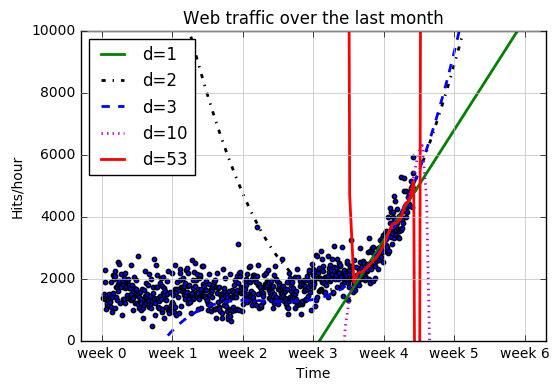

In [32]:
plot_models(
    x, y, [fb1, fb2, fb3, fb10, fb100], "../figures/1400_01_07.png",
    mx=sp.linspace(0 * 7 * 24, 6 * 7 * 24, 100),
    ymax=10000, xmin=0 * 7 * 24)

### Training and Testing

Let's split our data into test and train so that we can figure out which best generalizes on unseen data.

Then we use the hold-out data to calculate the error. As the model has been trained not knowing the hold-out data, we should get a more realistic picture of how the model will behave in the future.

The test errors for the models trained only on the time after the inflection point now show a completely different picture.

In [34]:
frac = 0.3
split_idx = int(frac * len(xb))

In [36]:
shuffled = sp.random.permutation(list(range(len(xb))))

In [37]:
test = sorted(shuffled[:split_idx])
train = sorted(shuffled[split_idx:])

In [45]:
fbt1 = sp.poly1d(sp.polyfit(xb.iloc[train], yb.iloc[train], 1))
fbt2 = sp.poly1d(sp.polyfit(xb.iloc[train], yb.iloc[train], 2))
fbt3 = sp.poly1d(sp.polyfit(xb.iloc[train], yb.iloc[train], 3))
fbt10 = sp.poly1d(sp.polyfit(xb.iloc[train], yb.iloc[train], 10))
fbt100 = sp.poly1d(sp.polyfit(xb.iloc[train], yb.iloc[train], 100))

//anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RankWarning: Polyfit may be poorly conditioned
//anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:5: RankWarning: Polyfit may be poorly conditioned


In [57]:
print("Test errors for only the time after inflection point")
for f in [fbt1, fbt2, fbt3, fbt10, fbt100]:
    print("Error d=%i: %f" % (f.order, error(f, xb.iloc[test], yb.iloc[test])))


Test errors for only the time after inflection point
Error d=1: 6782111.420381
Error d=2: 5642771.861778
Error d=3: 5695487.819187
Error d=10: 6052132.392708
Error d=53: 6708000.827457


Now that's what I'm talkin about...these errors are much lower

Take a look at the model with d=2 - it has the lowest test error aka the error when measured using data that the model did not see during training. it was held out.

The fact that it was unseen allows us to put faith inand trust that this data generalizes on future data.


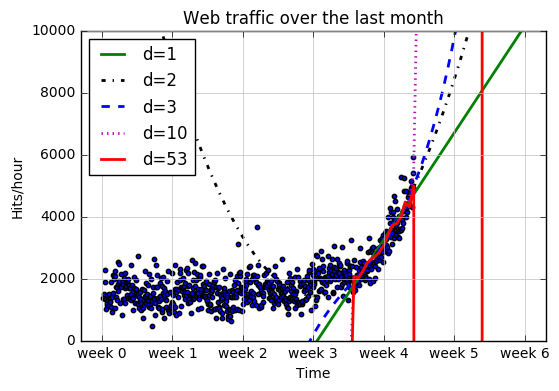

In [58]:
plot_models(
    x, y, [fbt1, fbt2, fbt3, fbt10, fbt100], os.path.join("..",
                                                          "1400_01_08.png"),
    mx=sp.linspace(0 * 7 * 24, 6 * 7 * 24, 100),
    ymax=10000, xmin=0 * 7 * 24)


### Conclusion

Let's answer the question that we were tasked with - WHen will our infrastucture reach 100,000 requests per hour?

We're going to go with polynomial of degree = 2, so we can do 2 things

1. Compute the inverse of the function and calculate its value at 100,000
2. Subtract 100,000 from the polynomial, which results in another polynomial, and finding the root of it. 
    SciPy's `optimize` module has the `fsolve` baked in and all we need to do is provide an initial starting position.

In [59]:
from scipy.optimize import fsolve
print(fbt2)
print()
print(fbt2 - 100000)
print()
reached_max = fsolve(fbt2 - 100000, 800) / (7 * 24)
print("100,000 hits/hour expected at week %f" % reached_max[0])


         2
0.06363 x - 64.71 x + 1.789e+04

         2
0.06363 x - 64.71 x - 8.211e+04

100,000 hits/hour expected at week 10.435298


From this we can conlude that given our current user behavior and success as a company, it'll take another month until we reach that capacity.

There is uncertainty involved in this prediction, so we'll need to build on this and include margin of err / confidence intervals / etc that we'll have to expect when looking into the future.

But this is good for now and we can monitor our requests closely and allocate new resources when necessary